In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [3]:
test_df = pd.read_csv('sign_mnist_test.csv')


In [4]:
test_df.rename(columns={'label':'Label'},inplace = True)

test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [6]:
test_df.iloc[:4,:10]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,4,173,175,177,181,183,186,190,191,190
1,24,177,179,180,181,182,182,183,183,184
2,1,167,169,170,171,173,172,171,171,171
3,7,199,201,202,204,205,206,207,209,209


In [8]:
printmd(f'### Number of images in the test set: {test_df.shape[0]}')

d = int((test_df.shape[1] - 1)**0.5)
printmd(f'### Shape of the images: {d} x {d}')

### Number of images in the test set: 7172

### Shape of the images: 28 x 28

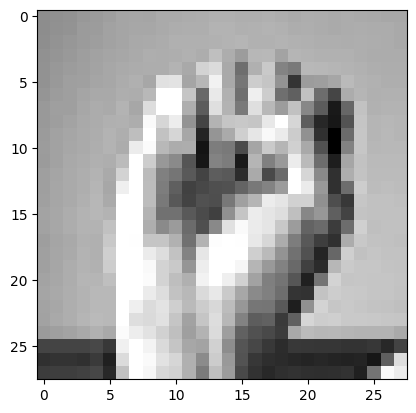

In [10]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)
        
# Display one image
img = to_image(test_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [11]:
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

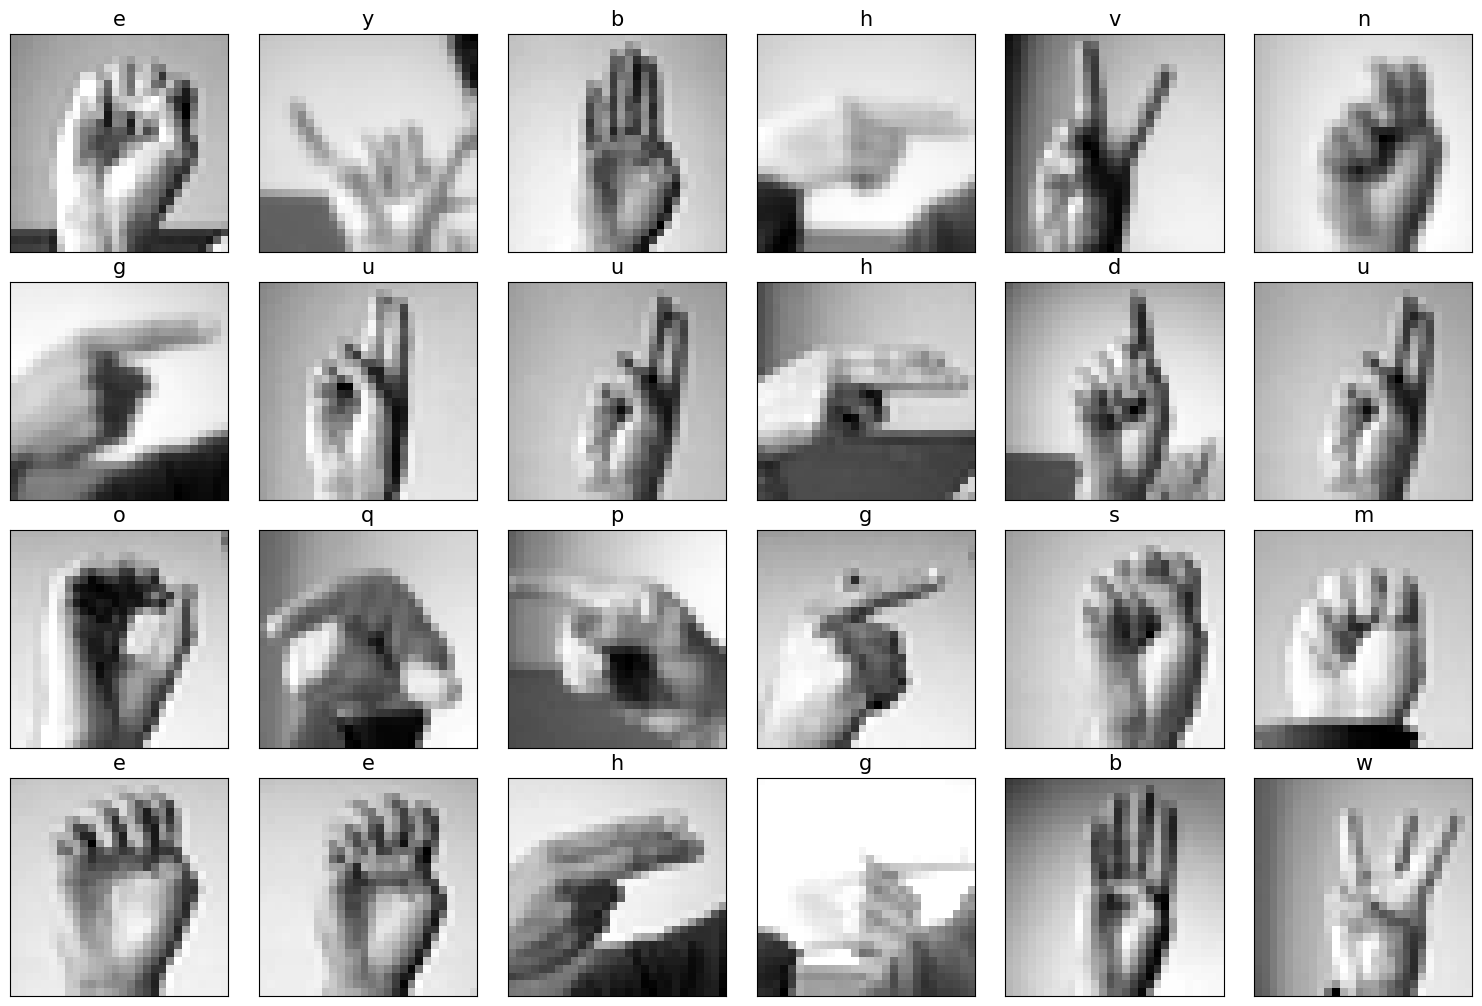

In [13]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(test_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[test_df.Label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

C:\Users\Akhilesh\AppData\Local\Temp\ipykernel_8536\4161818499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")


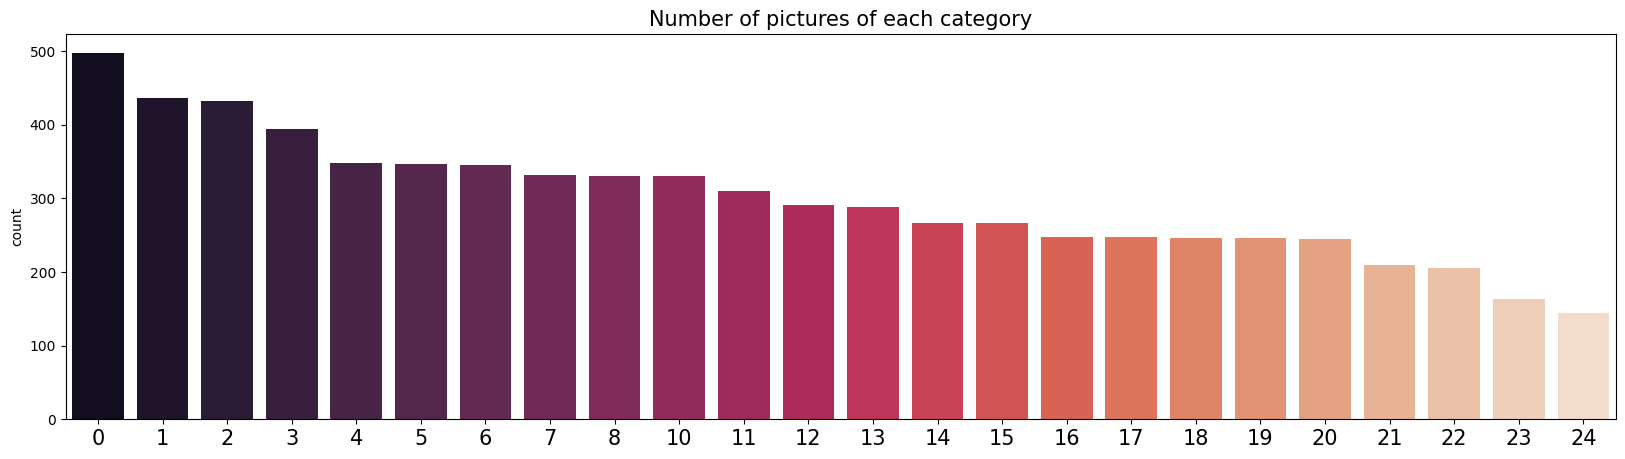

In [14]:
vc = test_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

In [15]:
train_df_original = test_df.copy()

# Split into training, test and validation sets
val_index = int(test_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [16]:
X_train.shape, X_val.shape, X_test.shape


((6455, 28, 28, 1), (717, 28, 28, 1), (7172, 28, 28, 1))

In [17]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)
# X_test_flow = generator.flow(X_test, y_test)

In [18]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

c:\Users\Akhilesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,994,649 (11.42 MB)

 Trainable params: 2,994,649 (11.42 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100


c:\Users\Akhilesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0722 - loss: 3.1881 - val_accuracy: 0.2245 - val_loss: 2.5296 - learning_rate: 0.0010
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3104 - loss: 2.1507 - val_accuracy: 0.6639 - val_loss: 0.9786 - learning_rate: 0.0010
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6522 - loss: 1.0060 - val_accuracy: 0.8438 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8165 - loss: 0.5395 - val_accuracy: 0.9289 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9016 - loss: 0.3034 - val_accuracy: 0.9582 - val_loss: 0.1386 - learning_rate: 0.0010
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9321 - loss: 0.2068 - val_accuracy: 0.9623 - val_loss: 0.1028 - learning_rate: 0.0010
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9489 - loss: 0.15

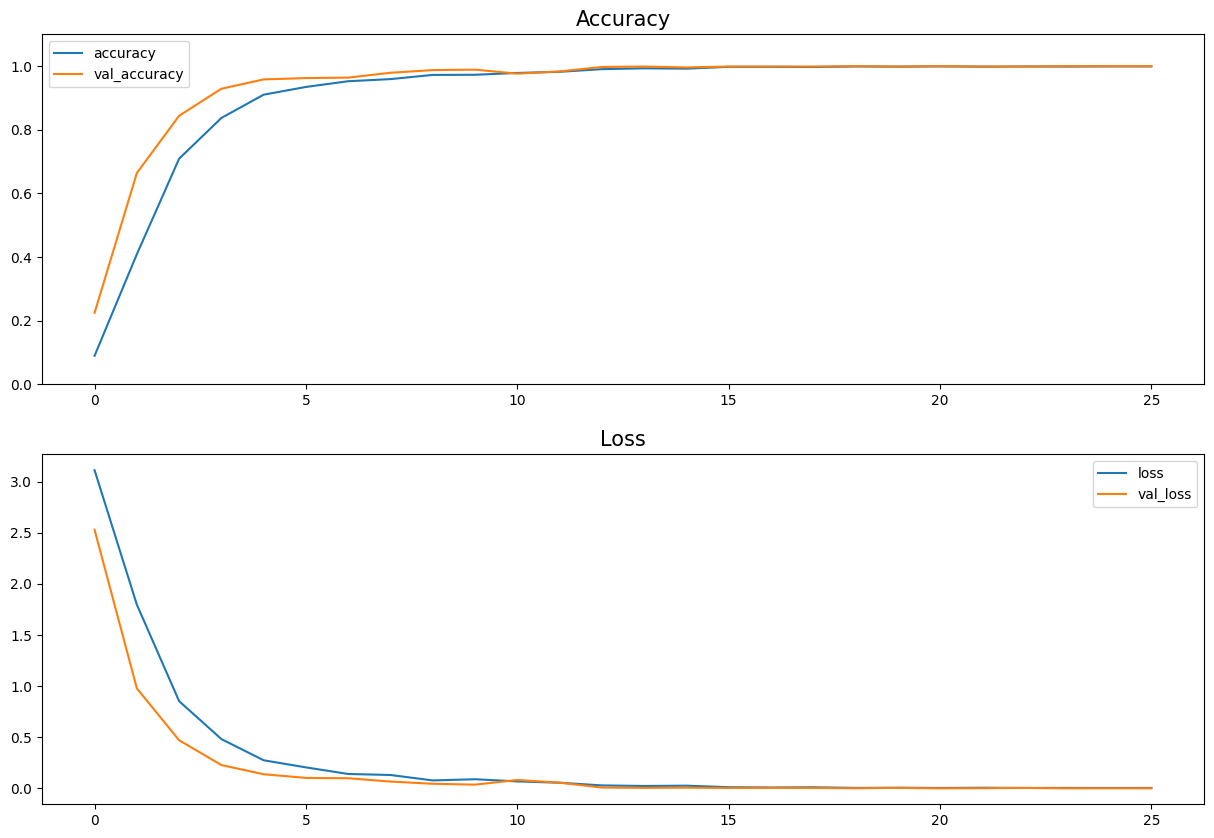

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [21]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


## 99.94% accuracy on the test set

In [22]:
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters = [mapping_letter[x] for x in pred]

In [23]:
print(classification_report(y_test_letters,pred_letters))


              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       0.99      1.00      1.00       432
           c       1.00      1.00      1.00       310
           d       1.00      0.98      0.99       245
           e       1.00      1.00      1.00       498
           f       1.00      1.00      1.00       247
           g       1.00      1.00      1.00       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       1.00      1.00      1.00       331
           l       1.00      1.00      1.00       209
           m       1.00      1.00      1.00       394
           n       1.00      1.00      1.00       291
           o       1.00      1.00      1.00       246
           p       1.00      1.00      1.00       347
           q       1.00      1.00      1.00       164
           r       1.00      1.00      1.00       144
           s       1.00    

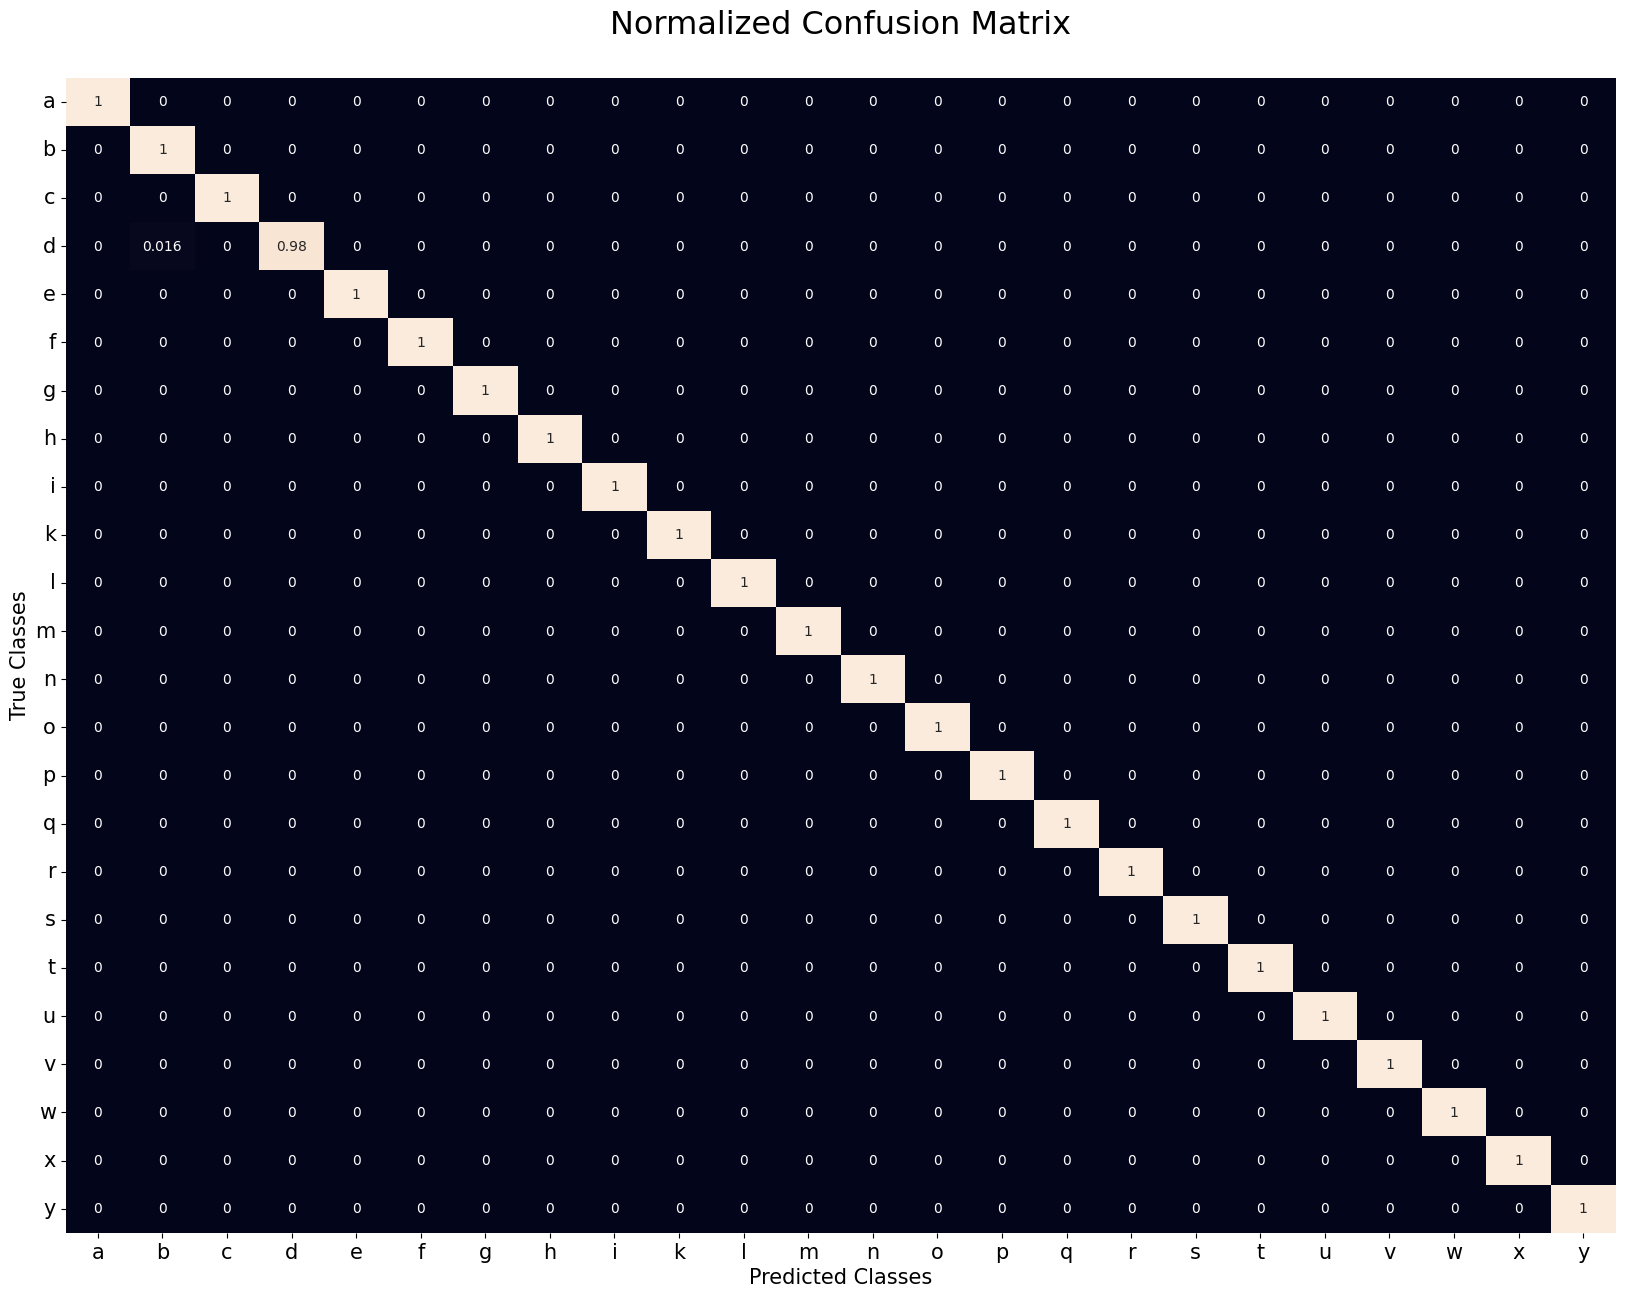

In [24]:
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()